In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend
from statsmodels.regression.linear_model import OLS
from scipy.signal import periodogram

## Loading data

,Year,Month,Day,Temperature
Date,,,,
1756-01-01,1756,1,1,-8.7
1756-01-02,1756,1,2,-9.2
1756-01-03,1756,1,3,-8.6
1756-01-04,1756,1,4,-7.7
1756-01-05,1756,1,5,-7.2
...,...,...,...,...
2017-12-27,2017,12,27,2.5
2017-12-28,2017,12,28,3.8
2017-12-29,2017,12,29,2.4


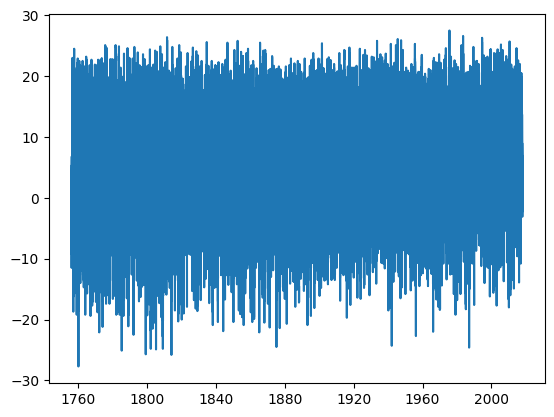

In [3]:
data=pd.read_csv("stockholm_daily_mean_temperature_1756_2017.txt",sep="\s+",header=None,usecols=[0,1,2,5],names=["Year","Month","Day","Temperature"])
data["Date"]=pd.to_datetime(data[["Year","Month","Day"]])
data.set_index("Date",inplace=True)
display(data)
plt.plot(data.index,data["Temperature"])
plt.show()


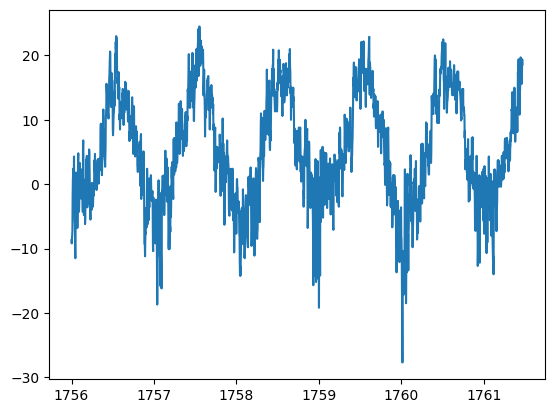

In [4]:
#Zooming in looking for periodicty
first_samples=data.head(2000)
plt.plot(first_samples.index,first_samples["Temperature"])
plt.show()

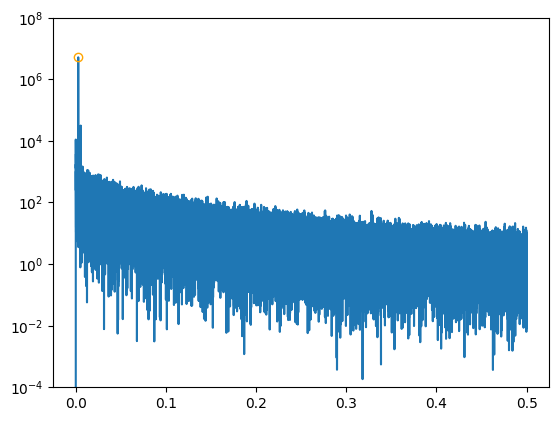

The peak is at 0.0027378937028444835 which corresponds to a period of 365.2442748091603 days.


In [5]:

f, px =periodogram(data["Temperature"])
plt.plot(f,px)
plt.yscale("log")
plt.ylim([1E-4,1E8])
max_p=np.max(px)
max_f=f[np.argmax(px)]
plt.plot(max_f,max_p,'o',markerfacecolor='none',markeredgecolor='orange')
plt.show()
print("The peak is at",max_f,"which corresponds to a period of",1/max_f,"days.")

## Cleaning the data

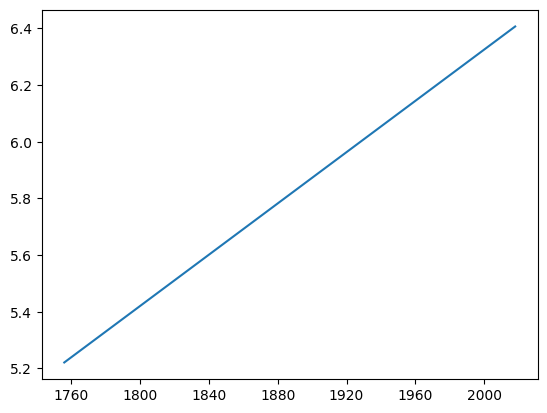

In [6]:
#Removing linear trend
data_detrended=detrend(data["Temperature"],order=1)
#We can see the linear model by
trend=data["Temperature"]-data_detrended
plt.plot(trend.index,trend)
plt.show()

In [7]:
seas_decompose_4_years=seasonal_decompose(data_detrended,period=365*4+1,filt=np.zeros(1000),extrapolate_trend=1)
seas_decompose_1_year=seasonal_decompose(data_detrended,period=365,filt=np.zeros(1000),extrapolate_trend=1)

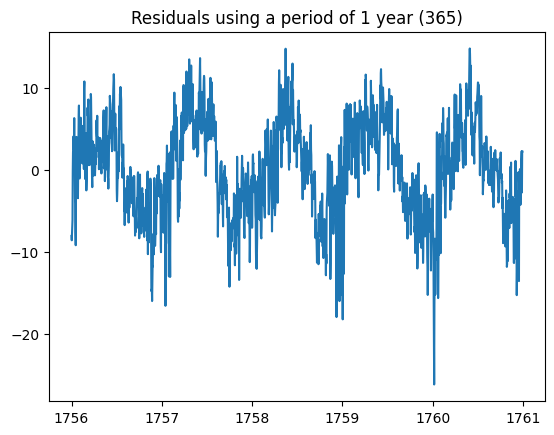

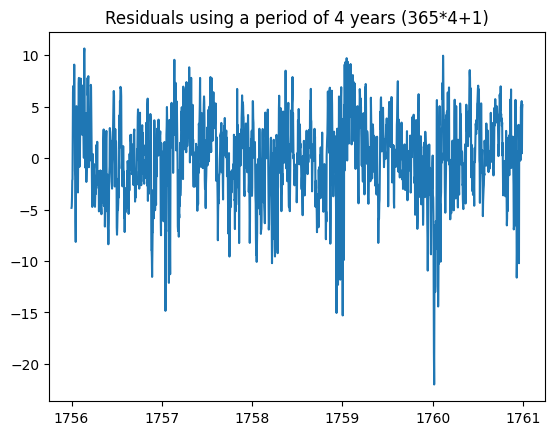

In [8]:
plt.plot(seas_decompose_1_year.resid.head(365*5).index,seas_decompose_1_year.resid.head(365*5))
plt.title("Residuals using a period of 1 year (365)")
plt.show()
plt.plot(seas_decompose_4_years.resid.head(365*5).index,seas_decompose_4_years.resid.head(365*5))
plt.title("Residuals using a period of 4 years (365*4+1)")
plt.show()

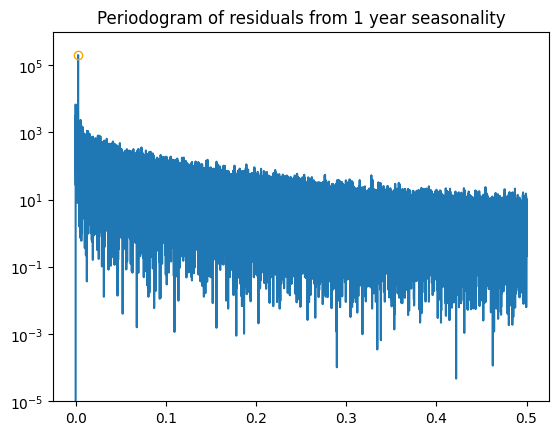

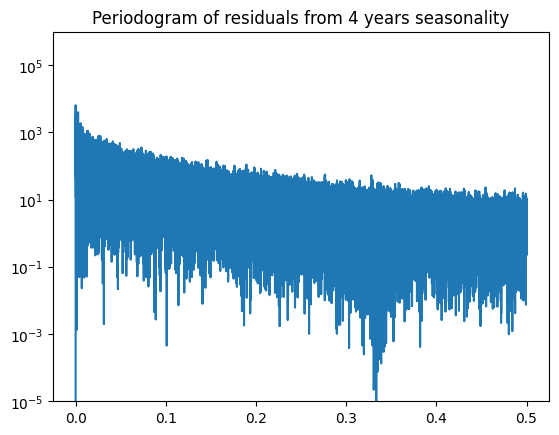

In [9]:
f, px =periodogram(seas_decompose_1_year.resid)
plt.plot(f,px)
plt.title("Periodogram of residuals from 1 year seasonality")
plt.yscale("log")
plt.ylim([1E-5,1E6])
max_p=np.max(px)
max_f=f[np.argmax(px)]
plt.plot(max_f,max_p,'o',markerfacecolor='none',markeredgecolor='orange')
plt.show()
f, px =periodogram(seas_decompose_4_years.resid)
plt.plot(f,px)
plt.title("Periodogram of residuals from 4 years seasonality")
plt.yscale("log")
plt.ylim([1E-5,1E6])
plt.show()

In [10]:
data_cleaned=seas_decompose_4_years.resid

## Fitting ARMA Models

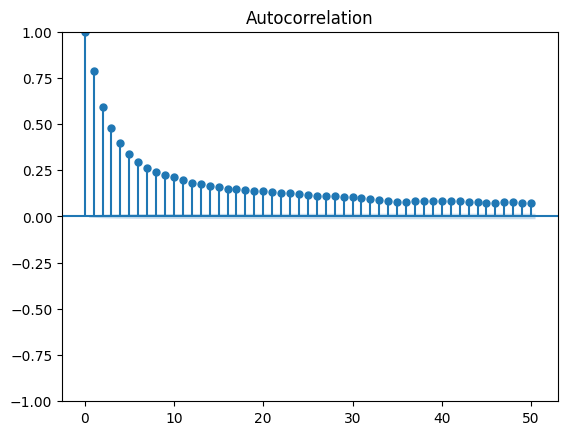

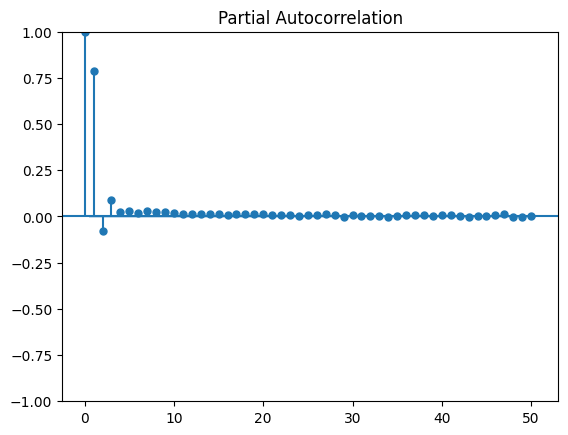

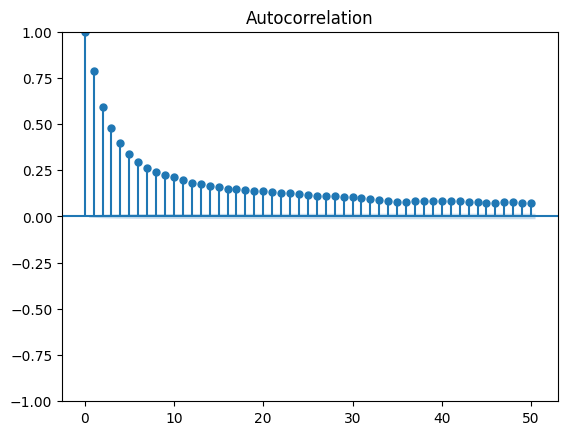

In [14]:
# TODO

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#from pmdarima import auto_arima

##Plot the acf and pacf to determine the order
plot_pacf(data_cleaned)
plot_acf(data_cleaned)
##The ACF decays geometrically, indicating that an ARMA model is suitable for fitting

In [30]:
maxp=3
maxq=3

aiccs=np.zeros((maxp+1,maxq+1)) 
aics=np.zeros((maxp+1,maxq+1)) 
bics=np.zeros((maxp+1,maxq+1)) 

for p in range(0,maxp+1):
  for q in range(0,maxq+1):
    model = ARIMA(data_cleaned, order=(p, 0 ,q)).fit(method= "innovations_mle")
    
    aiccs[p-1,q-1]=model.aicc
    aics[p-1,q-1]=model.aic
    bics[p-1,q-1]=model.bic

'''
ind = np.argmin(aiccs)
model = ARIMA(data_cleaned, order= orders[ind]).fit(method= "innovations_mle")
print(aiccs)
print(orders)
print(orders[ind])
'''

c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ollob\AppData\Local\Programs\Python\Python310\lib\s

'\nind = np.argmin(aiccs)\nmodel = ARIMA(data_cleaned, order= orders[ind]).fit(method= "innovations_mle")\nprint(aiccs)\nprint(orders)\nprint(orders[ind])\n'

In [31]:
print(aiccs)
print(aics)
print(bics)

[[429484.33596239 428889.02015596 428716.41869521 430191.85544694]
 [429186.07433887 428343.1018601  428254.75583228 429630.31145459]
 [428495.4494437  428272.05081587 428249.0673179  428869.70437322]
 [462141.1299214  443902.53604167 436884.49625021 523351.92284316]]
[[429484.33554437 428889.01952893 428716.41781735 430191.85519613]
 [429186.07371183 428343.10098224 428254.75466178 429630.31103657]
 [428495.44856584 428272.04964537 428249.06581296 428869.70374618]
 [462141.12967059 443902.53562364 436884.49562318 523351.92271776]]
[[429522.21118789 428936.36408332 428773.23128262 430220.26192877]
 [429233.41826623 428399.91444752 428321.03703794 429668.18668009]
 [428552.26203111 428338.33202153 428324.81709999 428917.04830058]
 [462169.53640323 443940.41126716 436931.84017757 523370.86053952]]


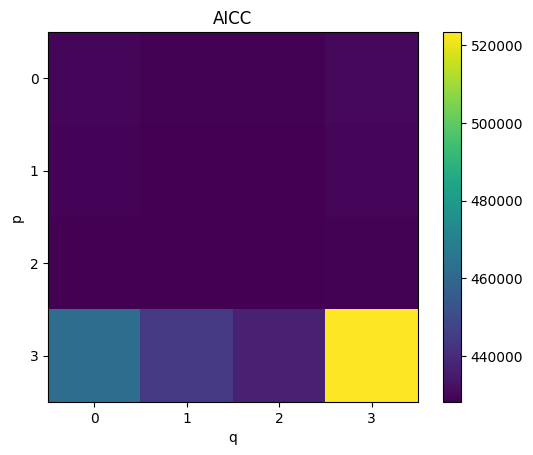

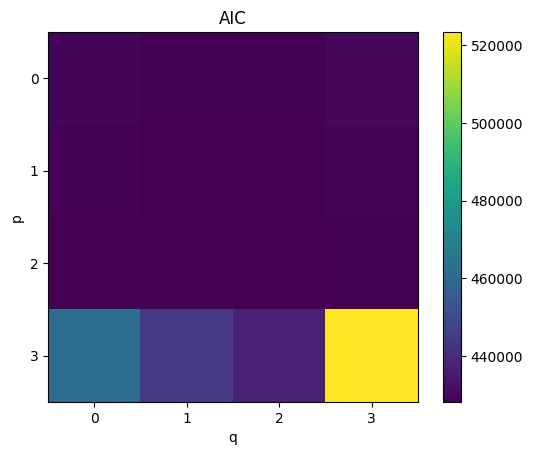

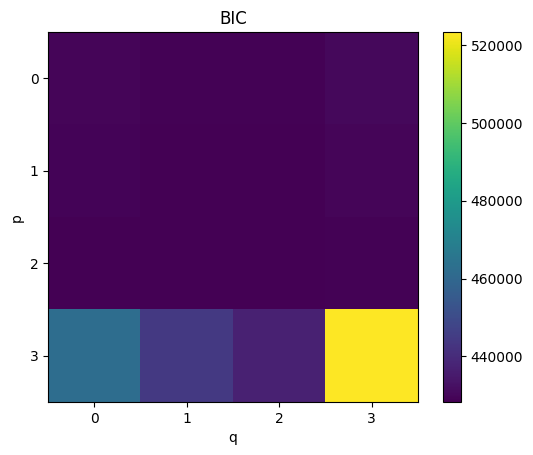

In [32]:
plt.imshow(aiccs,vmin=aiccs.min(),vmax=aiccs.max())
plt.yticks(range(maxp+1),range(maxp+1))
plt.xticks(range(maxq+1),range(maxq+1))
plt.colorbar()
plt.title("AICC")
plt.xlabel("q")
plt.ylabel("p")
plt.show()
plt.imshow(aics,vmin=aics.min(),vmax=aics.max())
plt.yticks(range(maxp+1),range(maxp+1))
plt.xticks(range(maxq+1),range(maxq+1))
plt.colorbar()
plt.title("AIC")
plt.xlabel("q")
plt.ylabel("p")
plt.show()
plt.imshow(bics,vmin=bics.min(),vmax=bics.max())
plt.yticks(range(maxp+1),range(maxp+1))
plt.xticks(range(maxq+1),range(maxq+1))
plt.colorbar()
plt.title("BIC")
plt.xlabel("q")
plt.ylabel("p")
plt.show()

In [34]:
best_params=np.unravel_index(np.argmin(aiccs), aiccs.shape)
print(best_params)
best_model=ARIMA(data_cleaned, order=(best_params[0], 0 ,best_params[1])).fit(method= "innovations_mle")

(2, 2)
